<a href="https://colab.research.google.com/github/itacademy-rogergallart/NoSupervisat_Classificacio/blob/main/S15_T01_NoSupervisat_Classificacio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# S15 T01: Classifica els diferents vols

Observacions:
1.   Notebook desenvolupat utilitzant Google Colab
2.   Repeteixo en aquest notebook part del preprocessament del dataset que ja haviem fet en tasques anteriors per tal que el notebook sigui "autocontingut"



## Exercici 1
Classifica els diferents vols utilitzant l'algorisme de K-means.

In [2]:
# Upgrade Sklearn (in Colab) to latest version 0.24.2
!pip install scikit-learn --upgrade  &> /dev/null

In [3]:
!pip install kneed &> /dev/null

In [4]:
!pip install kmodes &> /dev/null

In [2]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler #OneHotEncoder, , FunctionTransformer
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import silhouette_score
from kmodes.kprototypes import KPrototypes

from tqdm.notebook import tqdm
from kneed import KneeLocator

#from sklearn.model_selection import train_test_split, cross_validate
#from sklearn.pipeline import Pipeline
#from sklearn.compose import ColumnTransformer#, TransformedTargetRegressor
#from sklearn import set_config
#from sklearn.metrics import classification_report
#from sklearn.preprocessing import LabelEncoder

#from sklearn.linear_model import LogisticRegression
#from sklearn.tree import DecisionTreeClassifier
#from sklearn.neighbors import KNeighborsClassifier
#from sklearn.svm import SVC
#from sklearn.base import clone


#import time
#from tabulate import tabulate
#from functools import partial
#from tempfile import mkdtemp
#from scipy.stats import iqr

In [3]:
# Notebook configuration

# Plots
%matplotlib inline

# Pandas
pd.set_option("display.max_columns", None) # Display all columns of DataFrame

# Progress bars
tqdm = partial(tqdm, position=0, leave=True)

# Constants
RS = 123  # Random_state constant value


In [4]:
# Import DataSet directly from Kaggle

# Note: we add '&> /dev/null' to avoid displaying output of terminal commands 

datasetName = 'giovamata/airlinedelaycauses'
zipName = 'airlinedelaycauses.zip'

# Delete files on '/content' folder in Google Colab
!rm /content/*.* &> /dev/null 

!pip install kaggle &> /dev/null

!wget -O kaggle.json https://www.dropbox.com/s/xm28qj0cdfopm6c/kaggle.json?dl=0 &> /dev/null
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json &> /dev/null

!kaggle datasets download $datasetName &> /dev/null

!unzip $zipName

Archive:  airlinedelaycauses.zip
  inflating: DelayedFlights.csv      
  inflating: st99_d00.dbf            
  inflating: st99_d00.shp            
  inflating: st99_d00.shx            


In [5]:
# We create a DataFrame
df = pd.read_csv('/content/DelayedFlights.csv', index_col=0)

# We can delete feature FlightNum as it does not bring any relevant information
# (it is arbitrary, there can be several flights with same number and different destinations)
df.drop(columns=['FlightNum'], inplace=True)

# We delete feature Year (all samples belong to same year 2008)
df.drop(columns=['Year'], inplace=True)

# Renaming of feature DayofMonth as DayOfMonth, for consistency
df.rename(columns = {'DayofMonth': 'DayOfMonth'}, inplace = True)

# Setting type of Month, DayOfMonth, DayOfWeek and CancellationCode as categorical
df[['Month','DayOfMonth','DayOfWeek', 'CancellationCode']] = df[['Month','DayOfMonth','DayOfWeek', 'CancellationCode']].astype('category')

# Setting type of Cancelled and Diverted as boolean
df[['Cancelled','Diverted']] = df[['Cancelled','Diverted']].astype('bool')

df.head()

/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,Month,DayOfMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,1,3,4,2003.0,1955,2211.0,2225,WN,N712SW,128.0,150.0,116.0,-14.0,8.0,IAD,TPA,810,4.0,8.0,False,N,False,NaN,NaN,NaN,NaN,NaN
1,1,3,4,754.0,735,1002.0,1000,WN,N772SW,128.0,145.0,113.0,2.0,19.0,IAD,TPA,810,5.0,10.0,False,N,False,NaN,NaN,NaN,NaN,NaN
2,1,3,4,628.0,620,804.0,750,WN,N428WN,96.0,90.0,76.0,14.0,8.0,IND,BWI,515,3.0,17.0,False,N,False,NaN,NaN,NaN,NaN,NaN
4,1,3,4,1829.0,1755,1959.0,1925,WN,N464WN,90.0,90.0,77.0,34.0,34.0,IND,BWI,515,3.0,10.0,False,N,False,2.0,0.0,0.0,0.0,32.0
5,1,3,4,1940.0,1915,2121.0,2110,WN,N726SW,101.0,115.0,87.0,11.0,25.0,IND,JAX,688,4.0,10.0,False,N,False,NaN,NaN,NaN,NaN,NaN


In [7]:
# Categorical features
cat_columns = ['Month', 'DayOfMonth', 'DayOfWeek','TailNum', 'UniqueCarrier', 'Dest', 'Origin', 'Cancelled', 'CancellationCode', 'Diverted']

# Numerical features (all the rest)
num_columns = ['DepTime', 'CRSDepTime', 'ArrTime', 'CRSArrTime', 'ActualElapsedTime',
               'CRSElapsedTime', 'AirTime', 'ArrDelay', 'DepDelay', 'Distance', 'TaxiIn', 'TaxiOut', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']

print(f"Categorical columns are: {cat_columns}")
print(f"Numerical columns are: {num_columns}")

Categorical columns are: ['Month', 'DayOfMonth', 'DayOfWeek', 'TailNum', 'UniqueCarrier', 'Dest', 'Origin', 'Cancelled', 'CancellationCode', 'Diverted']
Numerical columns are: ['DepTime', 'CRSDepTime', 'ArrTime', 'CRSArrTime', 'ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'ArrDelay', 'DepDelay', 'Distance', 'TaxiIn', 'TaxiOut', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']


### Kmeans sense variables categòriques

In [8]:
# If we only use numerical values
df_num = df[num_columns].copy()  
df_num.head()

,DepTime,CRSDepTime,ArrTime,CRSArrTime,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Distance,TaxiIn,TaxiOut,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2003.0,1955,2211.0,2225,128.0,150.0,116.0,-14.0,8.0,810,4.0,8.0,NaN,NaN,NaN,NaN,NaN
1,754.0,735,1002.0,1000,128.0,145.0,113.0,2.0,19.0,810,5.0,10.0,NaN,NaN,NaN,NaN,NaN
2,628.0,620,804.0,750,96.0,90.0,76.0,14.0,8.0,515,3.0,17.0,NaN,NaN,NaN,NaN,NaN
4,1829.0,1755,1959.0,1925,90.0,90.0,77.0,34.0,34.0,515,3.0,10.0,2.0,0.0,0.0,0.0,32.0
5,1940.0,1915,2121.0,2110,101.0,115.0,87.0,11.0,25.0,688,4.0,10.0,NaN,NaN,NaN,NaN,NaN


In [9]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_num.dropna())

Provem fent una reducció de variables amb PCA utilitzant 2 o 3 components, per veure quin ens dona millor resultat. I busquem per cada cas el nombre de clusters òptim.

In [ ]:
# PCA components = 2

pca_features = PCA(n_components=2, random_state=RS).fit_transform(scaled_features)

kmeans_kwargs = {
    "init": "k-means++",
    "n_init": 10,
    "max_iter": 100,
    "random_state": RS,
}

# Iterations to determine optimal number of cluster k
sse = []
silhouette_coefficients = []

k_min, k_max = 2, 12

for k in tqdm(range(k_min, k_max)):
  kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
  kmeans.fit(pca_features)
  sse.append(kmeans.inertia_)
  score = silhouette_score(pca_features, kmeans.labels_, sample_size=5_000, random_state=RS)
  silhouette_coefficients.append(score)

k_elbow = KneeLocator(range(k_min, k_max), sse, curve="convex", direction="decreasing").elbow
sse_elbow = sse[k_elbow - k_min]

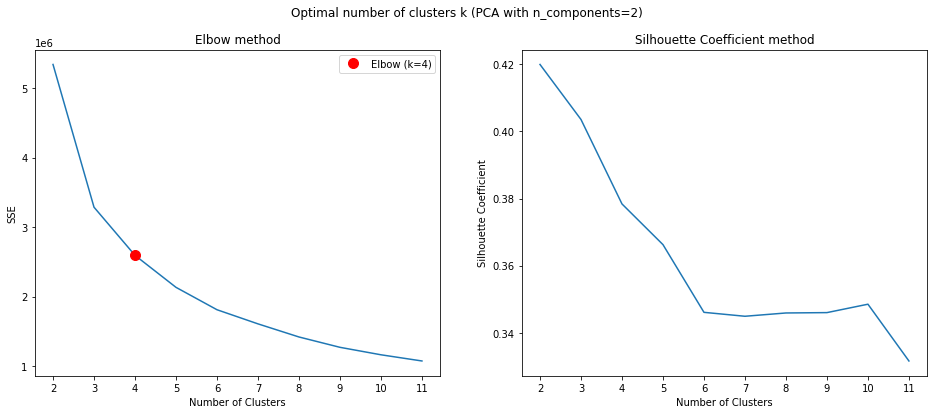

In [12]:
plt.figure(figsize=(16,6))
plt.suptitle('Optimal number of clusters k (PCA with n_components=2)')
plt.subplot(1,2,1)
plt.plot(range(k_min, k_max), sse)
plt.plot(k_elbow, sse_elbow,'ro', markersize=10, label=f'Elbow (k={k_elbow})')
plt.xticks(range(k_min, k_max))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.title(f"Elbow method")
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(k_min, k_max), silhouette_coefficients)
plt.xticks(range(k_min, k_max))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.title("Silhouette Coefficient method")
plt.show()

In [ ]:
# PCA components = 3

pca_features = PCA(n_components=3, random_state=RS).fit_transform(scaled_features)

kmeans_kwargs = {
    "init": "k-means++",
    "n_init": 10,
    "max_iter": 100,
    "random_state": RS,
}

# Iterations to determine optimal number of cluster k
sse = []
silhouette_coefficients = []

k_min, k_max = 2, 12

for k in tqdm(range(k_min, k_max)):
  kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
  kmeans.fit(pca_features)
  sse.append(kmeans.inertia_)
  score = silhouette_score(pca_features, kmeans.labels_, sample_size=5_000, random_state=RS)
  silhouette_coefficients.append(score)

k_elbow = KneeLocator(range(k_min, k_max), sse, curve="convex", direction="decreasing").elbow
sse_elbow = sse[k_elbow - k_min]


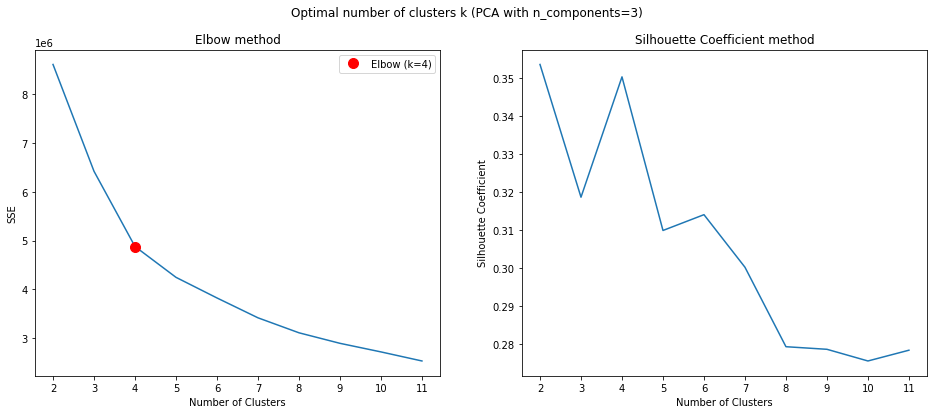

In [14]:
plt.figure(figsize=(16,6))
plt.suptitle('Optimal number of clusters k (PCA with n_components=3)')
plt.subplot(1,2,1)
plt.plot(range(k_min, k_max), sse)
plt.plot(k_elbow, sse_elbow,'ro', markersize=10, label=f'Elbow (k={k_elbow})')
plt.xticks(range(k_min, k_max))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.title(f"Elbow method")
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(k_min, k_max), silhouette_coefficients)
plt.xticks(range(k_min, k_max))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.title("Silhouette Coefficient method")
plt.show()


Triem PCA de 2 components i Kmeans amb 4 clusters


In [15]:
# 2 PCA components, k=4 clusters
pca_features = PCA(n_components=2, random_state=RS).fit_transform(scaled_features)
kmeans = KMeans(n_clusters=4, **kmeans_kwargs)
kmeans.fit(pca_features)

df_num = df_num.dropna()
df_num['pca_1'] = pca_features[:,0]
df_num['pca_2'] = pca_features[:,1]
df_num['label'] = kmeans.labels_

centers_x = kmeans.cluster_centers_[:,0]
centers_y = kmeans.cluster_centers_[:,1]

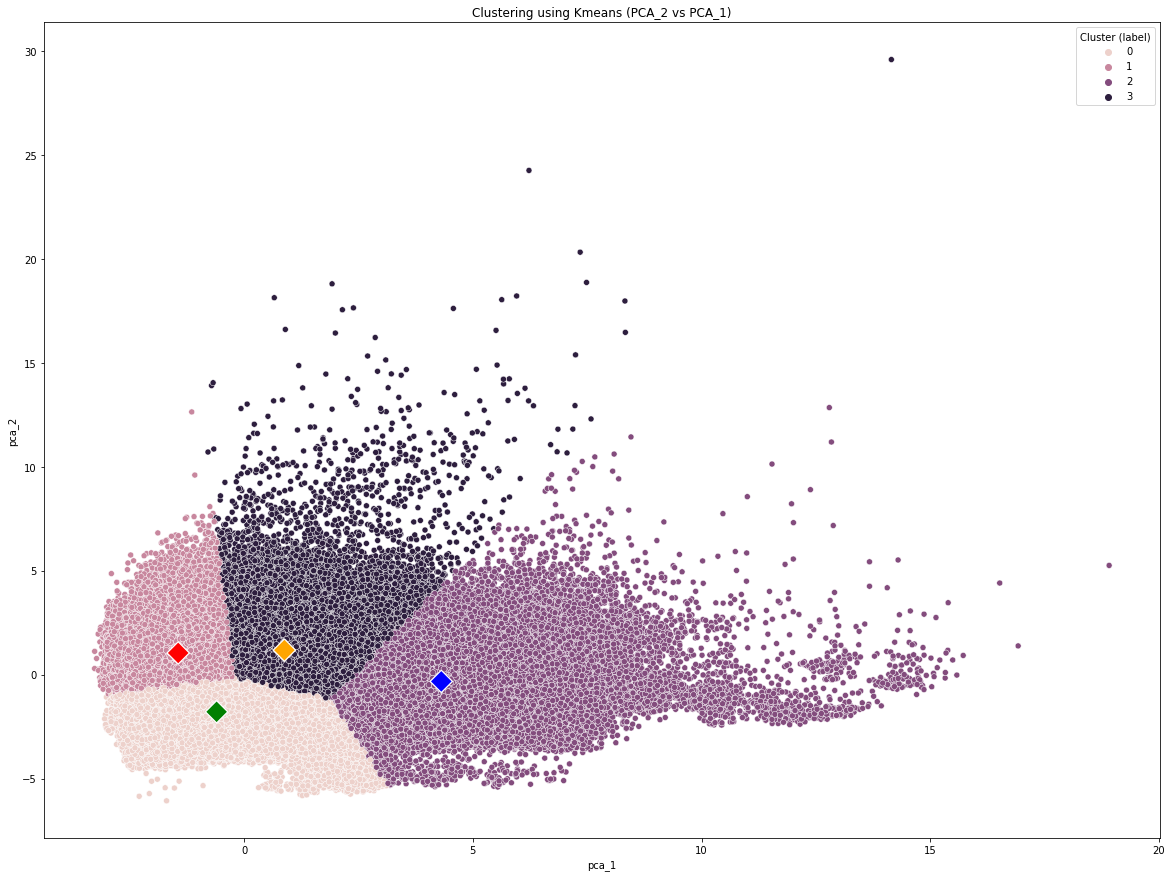

In [16]:
plt.figure(figsize=(20,15))
sns.scatterplot(data=df_num, x='pca_1', y='pca_2', hue='label')
sns.scatterplot(x=centers_x, y=centers_y, marker = "D", s=250,linewidths = 5, zorder = 10, c=['green', 'red','blue', 'orange'])
plt.title('Clustering using Kmeans (PCA_2 vs PCA_1)')
plt.legend(title='Cluster (label)')

Fem un resum estadístic de cada cluster.

In [17]:
# Statistical summary of each cluster

for k in range(0,4):
  print(f'\nStatistical summary for cluster {k}')
  display(df_num[df_num.label==k].drop(columns=['label']).describe(percentiles=[0.5]))


Statistical summary for cluster 0


,DepTime,CRSDepTime,ArrTime,CRSArrTime,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Distance,TaxiIn,TaxiOut,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,pca_1,pca_2
count,406741.000000,406741.000000,406741.000000,406741.000000,406741.000000,406741.000000,406741.000000,406741.000000,406741.000000,406741.000000,406741.000000,406741.000000,406741.000000,406741.000000,406741.000000,406741.000000,406741.000000,406741.000000,406741.000000
mean,1142.676546,1093.006985,1286.214650,1217.278037,111.410731,108.178300,85.605289,42.691460,39.459034,558.234046,6.833971,18.971471,18.386007,2.355283,9.949302,0.130373,11.870495,-0.602412,-1.788793
std,294.691507,301.723769,307.983117,315.909226,40.033095,38.328427,37.579386,30.946598,31.050382,304.511081,4.809030,12.381293,29.205016,12.345276,19.223644,2.424458,19.654441,1.084159,0.910498
min,1.000000,0.000000,1.000000,0.000000,15.000000,2.000000,1.000000,15.000000,6.000000,11.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-3.051338,-6.072604
50%,1142.000000,1105.000000,1326.000000,1240.000000,107.000000,105.000000,81.000000,32.000000,31.000000,522.000000,6.000000,15.000000,7.000000,0.000000,1.000000,0.000000,0.000000,-0.720311,-1.670325
max,2400.000000,2359.000000,1954.000000,2359.000000,275.000000,266.000000,226.000000,392.000000,405.000000,1754.000000,138.000000,197.000000,299.000000,269.000000,288.000000,392.000000,236.000000,3.105220,-0.131925



Statistical summary for cluster 1


,DepTime,CRSDepTime,ArrTime,CRSArrTime,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Distance,TaxiIn,TaxiOut,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,pca_1,pca_2
count,417885.000000,417885.000000,417885.000000,417885.000000,417885.000000,417885.000000,417885.000000,417885.000000,417885.000000,417885.000000,417885.000000,417885.000000,417885.000000,417885.000000,417885.000000,417885.000000,417885.000000,417885.000000,417885.000000
mean,1851.657202,1767.184438,1861.347131,1908.582256,85.396545,84.947837,61.245393,65.770942,65.322232,372.074214,6.544116,17.607035,17.385324,4.171564,10.705156,0.055130,33.453768,-1.438625,1.044754
std,295.050120,252.360248,524.969981,262.784316,23.846372,22.627874,20.977883,55.007674,55.110163,168.037363,4.742944,11.867596,38.626298,22.378301,27.231374,1.408939,45.759346,0.621299,0.947284
min,1.000000,440.000000,1.000000,1.000000,14.000000,-21.000000,0.000000,15.000000,6.000000,11.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-3.269984,-0.923921
50%,1851.000000,1755.000000,1954.000000,1925.000000,84.000000,84.000000,60.000000,48.000000,48.000000,349.000000,5.000000,14.000000,0.000000,0.000000,0.000000,0.000000,18.000000,-1.461965,1.004260
max,2400.000000,2359.000000,2400.000000,2359.000000,174.000000,171.000000,145.000000,878.000000,885.000000,935.000000,96.000000,143.000000,767.000000,878.000000,493.000000,216.000000,850.000000,-0.209464,12.642012



Statistical summary for cluster 2


,DepTime,CRSDepTime,ArrTime,CRSArrTime,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Distance,TaxiIn,TaxiOut,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,pca_1,pca_2
count,137334.000000,137334.000000,137334.000000,137334.000000,137334.000000,137334.000000,137334.000000,137334.000000,137334.000000,137334.000000,137334.000000,137334.000000,137334.000000,137334.000000,137334.000000,137334.000000,137334.000000,137334.000000,137334.000000
mean,1419.637096,1407.534878,1522.732819,1587.959078,288.876229,281.167060,255.110169,63.151565,55.442396,1963.179519,8.417267,25.348792,21.609201,2.664540,19.178201,0.137905,19.561718,4.315641,-0.329147
std,497.788749,454.752790,655.565848,553.981800,59.853786,57.719475,56.856833,59.979887,58.249014,473.877524,7.621255,22.811133,45.327550,16.835262,34.828661,2.697193,36.818868,1.590174,1.533458
min,1.000000,1.000000,1.000000,1.000000,172.000000,64.000000,43.000000,15.000000,6.000000,201.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.896772,-5.409209
50%,1419.000000,1350.000000,1711.000000,1712.000000,277.000000,270.000000,246.000000,43.000000,38.000000,1848.000000,7.000000,19.000000,7.000000,0.000000,7.000000,0.000000,0.000000,3.942738,-0.320457
max,2400.000000,2359.000000,2400.000000,2359.000000,1114.000000,660.000000,1091.000000,1382.000000,1395.000000,4962.000000,240.000000,422.000000,1382.000000,773.000000,890.000000,280.000000,686.000000,18.910345,12.851116



Statistical summary for cluster 3


,DepTime,CRSDepTime,ArrTime,CRSArrTime,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Distance,TaxiIn,TaxiOut,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,pca_1,pca_2
count,285528.000000,285528.000000,285528.000000,285528.000000,285528.000000,285528.000000,285528.000000,285528.000000,285528.000000,285528.000000,285528.000000,285528.000000,285528.000000,285528.00000,285528.000000,285528.000000,285528.000000,285528.000000,285528.000000
mean,1790.041005,1680.555189,1774.842754,1928.552131,168.839858,162.020086,135.039334,89.073958,82.254161,956.010440,8.520681,25.279843,21.766632,5.43906,26.565444,0.061080,35.241742,0.887903,1.177438
std,310.742772,275.957418,687.153719,310.852993,32.721740,32.043665,32.297548,85.586949,84.038228,272.276114,7.873543,22.161900,62.313349,30.42151,50.995129,1.758328,54.693764,0.830355,1.146682
min,1.000000,50.000000,1.000000,1.000000,34.000000,40.000000,0.000000,15.000000,6.000000,56.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,-0.790663,-1.174628
50%,1823.000000,1720.000000,2012.000000,1953.000000,164.000000,160.000000,132.000000,64.000000,58.000000,944.000000,6.000000,18.000000,0.000000,0.00000,6.000000,0.000000,14.000000,0.746521,1.108097
max,2400.000000,2358.000000,2400.000000,2359.000000,459.000000,455.000000,437.000000,2461.000000,2467.000000,3972.000000,186.000000,336.000000,2436.000000,1352.00000,1357.000000,357.000000,1316.000000,14.149318,29.597871


### Kmprototypes amb variables numèriques i categòriques

Kprototypes és una evolució de Kmeans que permet treballar amb variables mixtes (numèriques i categòriques). És un algoritme costós, enlloc de fer servir totes les dades utilitzarem només una mostra.

In [18]:
# Categorical columns indices
cat_idx = [df.columns.get_loc(col) for col in cat_columns]

# Model
kproto = KPrototypes(n_clusters=2, max_iter=20)

In [ ]:
# We use the elbow method to find the optimal number of clusters

N = 1_000 # samples
k_min, k_max = 2, 12

df_num_cat = df.dropna().sample(N)

cost = []

for k in tqdm(range(k_min, k_max)):
  kprototype = KPrototypes(n_jobs = -1, n_clusters = k, init = 'Huang', random_state = RS)
  kprototype.fit_predict(df_num_cat.values, categorical=cat_idx)
  cost.append(kprototype.cost_)

k_elbow = KneeLocator(range(k_min, k_max), cost, curve="convex", direction="decreasing").elbow
cost_elbow = cost[k_elbow - k_min]


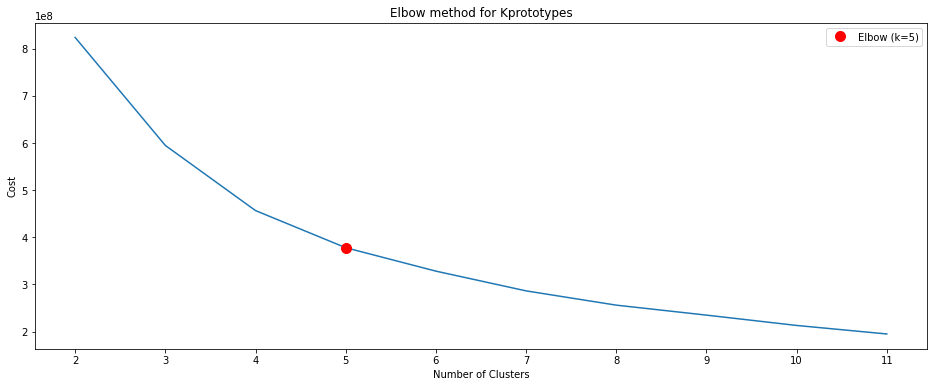

In [20]:
plt.figure(figsize=(16,6))
plt.plot(range(k_min, k_max), cost)
plt.plot(k_elbow, cost_elbow,'ro', markersize=10, label=f'Elbow (k={k_elbow})')
plt.xticks(range(k_min, k_max))
plt.xlabel("Number of Clusters")
plt.ylabel("Cost")
plt.title(f"Elbow method for Kprototypes")
plt.legend()
plt.show()

Triem k=5 clusters.

In [21]:
N = 1_000 # samples
K = 5 # clusters

kprototype = KPrototypes(n_jobs = -1, n_clusters = K, init = 'Huang', random_state = RS)
kprototype.fit_predict(df_num_cat.values, categorical=cat_idx)

df_num_cat['label'] = kprototype.labels_

# Statistical summary of each cluster
for k in range(0,K):
  print(f'\nStatistical summary for group {k}')
  display(df_num_cat[df_num_cat.label==k].drop(columns=['label']).describe(percentiles=[0.5], include='all'))


Statistical summary for group 0


,Month,DayOfMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
count,311.0,311.0,311.0,311.000000,311.000000,311.000000,311.000000,311,311,311.000000,311.000000,311.000000,311.000000,311.000000,311,311,311.000000,311.000000,311.000000,311,311,311,311.000000,311.000000,311.000000,311.000000,311.000000
unique,12.0,31.0,7.0,NaN,NaN,NaN,NaN,20,295,NaN,NaN,NaN,NaN,NaN,106,102,NaN,NaN,NaN,1,1,1,NaN,NaN,NaN,NaN,NaN
top,12.0,1.0,5.0,NaN,NaN,NaN,NaN,WN,85879E,NaN,NaN,NaN,NaN,NaN,ATL,ATL,NaN,NaN,NaN,False,N,False,NaN,NaN,NaN,NaN,NaN
freq,36.0,16.0,61.0,NaN,NaN,NaN,NaN,56,3,NaN,NaN,NaN,NaN,NaN,19,23,NaN,NaN,NaN,311,311,311,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,1517.643087,1431.652733,1699.919614,1608.951768,NaN,NaN,112.180064,109.517685,85.369775,54.826367,52.163987,NaN,NaN,559.511254,7.086817,19.723473,NaN,NaN,NaN,18.254019,4.389068,11.086817,0.080386,21.016077
std,NaN,NaN,NaN,149.591329,153.598140,154.730640,150.022195,NaN,NaN,45.219177,41.221888,40.108984,47.161309,46.013414,NaN,NaN,315.567414,4.949635,16.198588,NaN,NaN,NaN,37.489221,20.075657,23.924253,1.258507,31.338574
min,NaN,NaN,NaN,1105.000000,906.000000,1358.000000,1224.000000,NaN,NaN,14.000000,24.000000,7.000000,15.000000,7.000000,NaN,NaN,31.000000,1.000000,1.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000
50%,NaN,NaN,NaN,1524.000000,1440.000000,1723.000000,1624.000000,NaN,NaN,106.000000,105.000000,82.000000,39.000000,38.000000,NaN,NaN,508.000000,6.000000,15.000000,NaN,NaN,NaN,3.000000,0.000000,0.000000,0.000000,11.000000
max,NaN,NaN,NaN,1958.000000,1737.000000,2050.000000,1941.000000,NaN,NaN,246.000000,210.000000,188.000000,383.000000,397.000000,NaN,NaN,1301.000000,45.000000,164.000000,NaN,NaN,NaN,383.000000,242.000000,160.000000,22.000000,226.000000



Statistical summary for group 1


,Month,DayOfMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
count,324.0,324.0,324.0,324.000000,324.000000,324.000000,324.000000,324,324,324.000000,324.000000,324.000000,324.000000,324.000000,324,324,324.000000,324.000000,324.000000,324,324,324,324.000000,324.000000,324.000000,324.000000,324.000000
unique,12.0,31.0,7.0,NaN,NaN,NaN,NaN,19,314,NaN,NaN,NaN,NaN,NaN,85,101,NaN,NaN,NaN,1,1,1,NaN,NaN,NaN,NaN,NaN
top,2.0,28.0,3.0,NaN,NaN,NaN,NaN,WN,N4YSAA,NaN,NaN,NaN,NaN,NaN,ORD,ORD,NaN,NaN,NaN,False,N,False,NaN,NaN,NaN,NaN,NaN
freq,38.0,16.0,58.0,NaN,NaN,NaN,NaN,78,2,NaN,NaN,NaN,NaN,NaN,24,19,NaN,NaN,NaN,324,324,324,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,1944.990741,1848.459877,2136.975309,2037.682099,NaN,NaN,120.379630,118.604938,91.941358,59.910494,58.135802,NaN,NaN,614.540123,7.820988,20.617284,NaN,NaN,NaN,15.604938,1.780864,14.401235,0.030864,28.092593
std,NaN,NaN,NaN,136.908265,145.224929,130.032597,137.164251,NaN,NaN,50.571419,48.257226,45.745083,53.444291,50.879449,NaN,NaN,360.795769,9.858695,16.914513,NaN,NaN,NaN,33.274235,8.825351,36.990662,0.555556,38.944162
min,NaN,NaN,NaN,1655.000000,1434.000000,1858.000000,1630.000000,NaN,NaN,34.000000,40.000000,23.000000,15.000000,6.000000,NaN,NaN,89.000000,1.000000,3.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000
50%,NaN,NaN,NaN,1938.500000,1840.000000,2129.500000,2029.000000,NaN,NaN,111.000000,110.000000,81.000000,43.000000,44.000000,NaN,NaN,529.000000,5.500000,16.000000,NaN,NaN,NaN,0.500000,0.000000,0.000000,0.000000,14.500000
max,NaN,NaN,NaN,2245.000000,2155.000000,2400.000000,2330.000000,NaN,NaN,322.000000,269.000000,259.000000,429.000000,398.000000,NaN,NaN,1728.000000,132.000000,131.000000,NaN,NaN,NaN,384.000000,94.000000,260.000000,10.000000,210.000000



Statistical summary for group 2


,Month,DayOfMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
count,68.0,68.0,68.0,68.000000,68.000000,68.000000,68.000000,68,68,68.000000,68.000000,68.000000,68.000000,68.000000,68,68,68.000000,68.000000,68.000000,68,68,68,68.000000,68.000000,68.000000,68.0,68.000000
unique,12.0,23.0,7.0,NaN,NaN,NaN,NaN,16,66,NaN,NaN,NaN,NaN,NaN,32,49,NaN,NaN,NaN,1,1,1,NaN,NaN,NaN,NaN,NaN
top,6.0,9.0,7.0,NaN,NaN,NaN,NaN,WN,N200AA,NaN,NaN,NaN,NaN,NaN,ORD,BOS,NaN,NaN,NaN,False,N,False,NaN,NaN,NaN,NaN,NaN
freq,12.0,6.0,16.0,NaN,NaN,NaN,NaN,10,2,NaN,NaN,NaN,NaN,NaN,9,4,NaN,NaN,NaN,68,68,68,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,2066.823529,2031.367647,64.588235,2063.676471,NaN,NaN,146.000000,141.720588,116.735294,110.323529,106.044118,NaN,NaN,840.529412,6.102941,23.161765,NaN,NaN,NaN,31.882353,5.661765,17.823529,0.0,54.955882
std,NaN,NaN,NaN,511.509091,156.450450,85.831532,645.083436,NaN,NaN,77.958083,72.277006,72.345279,81.359978,75.551195,NaN,NaN,556.570803,4.221974,17.507875,NaN,NaN,NaN,59.960069,19.177576,41.946640,0.0,69.972155
min,NaN,NaN,NaN,37.000000,1550.000000,1.000000,5.000000,NaN,NaN,23.000000,30.000000,11.000000,15.000000,15.000000,NaN,NaN,41.000000,2.000000,7.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.0,0.000000
50%,NaN,NaN,NaN,2217.500000,2050.000000,37.000000,2301.000000,NaN,NaN,138.000000,132.000000,103.500000,82.000000,84.000000,NaN,NaN,746.500000,5.000000,15.000000,NaN,NaN,NaN,5.000000,0.000000,0.000000,0.0,25.500000
max,NaN,NaN,NaN,2400.000000,2325.000000,448.000000,2359.000000,NaN,NaN,479.000000,388.000000,399.000000,399.000000,307.000000,NaN,NaN,2586.000000,27.000000,76.000000,NaN,NaN,NaN,330.000000,95.000000,247.000000,0.0,275.000000



Statistical summary for group 3


,Month,DayOfMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
count,83.0,83.0,83.0,83.000000,83.000000,83.000000,83.000000,83,83,83.000000,83.000000,83.000000,83.000000,83.000000,83,83,83.000000,83.000000,83.000000,83,83,83,83.000000,83.000000,83.000000,83.0,83.000000
unique,12.0,30.0,7.0,NaN,NaN,NaN,NaN,11,82,NaN,NaN,NaN,NaN,NaN,36,30,NaN,NaN,NaN,1,1,1,NaN,NaN,NaN,NaN,NaN
top,2.0,16.0,2.0,NaN,NaN,NaN,NaN,UA,N816AW,NaN,NaN,NaN,NaN,NaN,SFO,LAS,NaN,NaN,NaN,False,N,False,NaN,NaN,NaN,NaN,NaN
freq,10.0,5.0,15.0,NaN,NaN,NaN,NaN,23,2,NaN,NaN,NaN,NaN,NaN,9,11,NaN,NaN,NaN,83,83,83,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,1349.120482,1345.313253,1682.120482,1583.036145,NaN,NaN,292.759036,285.192771,262.939759,61.493976,53.927711,NaN,NaN,2027.060241,6.807229,23.012048,NaN,NaN,NaN,24.012048,3.301205,17.831325,0.0,16.349398
std,NaN,NaN,NaN,466.406878,437.502500,470.081840,471.183498,NaN,NaN,77.653010,74.007161,72.206065,57.578446,55.397187,NaN,NaN,597.991972,4.462466,22.013573,NaN,NaN,NaN,49.596050,15.599980,26.108974,0.0,28.375287
min,NaN,NaN,NaN,21.000000,159.000000,107.000000,25.000000,NaN,NaN,178.000000,185.000000,152.000000,15.000000,6.000000,NaN,NaN,1312.000000,2.000000,5.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.0,0.000000
50%,NaN,NaN,NaN,1341.000000,1310.000000,1756.000000,1720.000000,NaN,NaN,281.000000,275.000000,259.000000,42.000000,30.000000,NaN,NaN,1846.000000,6.000000,16.000000,NaN,NaN,NaN,6.000000,0.000000,6.000000,0.0,2.000000
max,NaN,NaN,NaN,2258.000000,2350.000000,2349.000000,2257.000000,NaN,NaN,659.000000,660.000000,636.000000,283.000000,252.000000,NaN,NaN,4962.000000,39.000000,160.000000,NaN,NaN,NaN,239.000000,103.000000,124.000000,0.0,170.000000



Statistical summary for group 4


,Month,DayOfMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
count,214.0,214.0,214.0,214.000000,214.000000,214.000000,214.000000,214,214,214.000000,214.000000,214.000000,214.000000,214.000000,214,214,214.000000,214.000000,214.000000,214,214,214,214.000000,214.000000,214.000000,214.000000,214.000000
unique,12.0,31.0,7.0,NaN,NaN,NaN,NaN,19,212,NaN,NaN,NaN,NaN,NaN,87,90,NaN,NaN,NaN,1,1,1,NaN,NaN,NaN,NaN,NaN
top,2.0,22.0,1.0,NaN,NaN,NaN,NaN,WN,N935EV,NaN,NaN,NaN,NaN,NaN,ORD,ORD,NaN,NaN,NaN,False,N,False,NaN,NaN,NaN,NaN,NaN
freq,33.0,13.0,41.0,NaN,NaN,NaN,NaN,30,2,NaN,NaN,NaN,NaN,NaN,18,18,NaN,NaN,NaN,214,214,214,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,983.453271,913.953271,1161.719626,1070.700935,NaN,NaN,110.509346,104.130841,83.037383,56.626168,50.247664,NaN,NaN,523.299065,6.925234,20.546729,NaN,NaN,NaN,25.528037,6.635514,13.985981,0.009346,10.467290
std,NaN,NaN,NaN,203.842490,210.813532,203.288079,203.997939,NaN,NaN,46.231175,45.144335,44.220940,62.761419,61.815106,NaN,NaN,359.645175,5.170703,14.603851,NaN,NaN,NaN,56.153183,35.330736,25.481740,0.136717,19.301812
min,NaN,NaN,NaN,31.000000,550.000000,148.000000,27.000000,NaN,NaN,32.000000,35.000000,19.000000,15.000000,6.000000,NaN,NaN,70.000000,1.000000,5.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000
50%,NaN,NaN,NaN,1011.500000,918.000000,1201.500000,1079.500000,NaN,NaN,101.500000,95.000000,75.000000,35.500000,33.000000,NaN,NaN,447.000000,6.000000,16.000000,NaN,NaN,NaN,7.000000,0.000000,4.000000,0.000000,0.000000
max,NaN,NaN,NaN,1502.000000,2259.000000,1613.000000,1413.000000,NaN,NaN,277.000000,268.000000,241.000000,441.000000,446.000000,NaN,NaN,1671.000000,55.000000,99.000000,NaN,NaN,NaN,441.000000,340.000000,155.000000,2.000000,92.000000


## Exercici 2
Classifica els diferents vols utilitzant l'algorisme de clustering jeràrquic.

L'algorisme de Hierarchical Clustering no es pot fer servir en datasets molt grans perquè requereix molta memòria i molt temps de processat (consumeix *O(n^2)* memoria i triga *O(n^3)*). Per això només podem aplicar-lo a una mostra petita del nostre dataset.

In [22]:
# We take  a random sample of our dataset

N = 1_000 # samples

number_of_rows = scaled_features.shape[0]
random_indices = np.random.choice(number_of_rows, size=N, replace=False)
random_rows = scaled_features[random_indices, :]

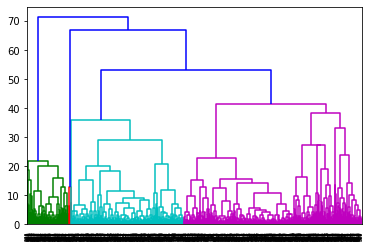

In [23]:
dendrogram = sch.dendrogram(sch.linkage(random_rows, method='ward'))

El nombre òptim de clusters és k=3.

In [24]:
K = 3 # clusters

model = AgglomerativeClustering(n_clusters=K, affinity='euclidean', linkage='ward')
model.fit(random_rows)

df_hierarchical = df_num.dropna().iloc[random_indices,:]
df_hierarchical['label'] = model.labels_

In [25]:
# Statistical summary of each cluster

for k in range(0,3):
  print(f'\nStatistical summary for group {k}')
  display(df_hierarchical[df_hierarchical.label==k].drop(columns=['label']).describe(percentiles=[0.5]))


Statistical summary for group 0


,DepTime,CRSDepTime,ArrTime,CRSArrTime,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Distance,TaxiIn,TaxiOut,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,pca_1,pca_2
count,868.000000,868.000000,868.000000,868.000000,868.000000,868.000000,868.000000,868.000000,868.000000,868.000000,868.000000,868.000000,868.000000,868.000000,868.000000,868.000000,868.000000,868.000000,868.000000
mean,1556.630184,1475.252304,1620.948157,1632.011521,111.852535,107.058756,83.443548,63.498848,58.705069,542.460829,7.157834,21.251152,18.822581,3.745392,15.213134,0.099078,25.618664,-0.677572,-0.042401
std,435.382440,413.727582,551.163798,444.791627,45.364640,40.695907,39.464031,51.159621,50.171224,321.663969,5.751222,16.592589,35.497205,20.304735,30.627907,1.847558,38.962656,1.207167,1.654055
min,47.000000,540.000000,3.000000,3.000000,35.000000,32.000000,13.000000,15.000000,6.000000,56.000000,1.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2.769173,-4.049479
50%,1616.500000,1515.000000,1724.500000,1700.000000,105.000000,101.000000,77.000000,47.000000,41.000000,475.000000,6.000000,16.000000,1.000000,0.000000,2.000000,0.000000,10.000000,-0.866803,0.108921
max,2358.000000,2359.000000,2400.000000,2359.000000,341.000000,250.000000,209.000000,383.000000,406.000000,1855.000000,60.000000,145.000000,248.000000,289.000000,303.000000,51.000000,221.000000,4.483214,4.365757



Statistical summary for group 1


,DepTime,CRSDepTime,ArrTime,CRSArrTime,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Distance,TaxiIn,TaxiOut,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,pca_1,pca_2
count,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.0,126.000000,126.000000,126.000000
mean,1381.968254,1353.293651,1498.230159,1535.587302,278.325397,272.928571,247.984127,57.246032,51.849206,1900.642857,7.579365,22.761905,17.738095,3.460317,18.246032,0.0,17.801587,4.049561,-0.568338
std,511.306639,471.163327,636.873365,556.485490,61.120842,58.034359,55.842777,47.104087,48.664906,519.335090,4.211134,17.359921,26.435485,15.528374,41.348797,0.0,29.594599,1.720415,1.694959
min,12.000000,45.000000,14.000000,30.000000,160.000000,168.000000,139.000000,15.000000,6.000000,951.000000,1.000000,5.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.869532,-5.094994
50%,1333.000000,1305.000000,1614.000000,1627.500000,261.000000,255.000000,234.500000,41.000000,33.500000,1746.000000,6.000000,17.000000,8.000000,0.000000,4.500000,0.0,0.500000,3.490775,-0.560756
max,2321.000000,2359.000000,2349.000000,2359.000000,486.000000,478.000000,457.000000,364.000000,356.000000,4243.000000,23.000000,102.000000,118.000000,129.000000,364.000000,0.0,136.000000,11.675979,3.535825



Statistical summary for group 2


,DepTime,CRSDepTime,ArrTime,CRSArrTime,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Distance,TaxiIn,TaxiOut,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,pca_1,pca_2
count,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.0,6.000000,6.0,6.000000,6.000000,6.000000
mean,1611.333333,955.333333,1492.166667,1239.500000,127.500000,130.833333,104.333333,632.666667,636.000000,742.333333,9.333333,13.833333,622.500000,0.0,3.833333,0.0,6.333333,1.242698,5.001380
std,501.626023,460.604675,851.016667,395.915521,45.213936,45.757695,49.330180,129.152107,141.633329,452.843314,3.723797,4.262237,131.041596,0.0,9.389711,0.0,15.513435,1.426120,1.552175
min,700.000000,630.000000,100.000000,902.000000,71.000000,77.000000,40.000000,466.000000,443.000000,231.000000,5.000000,9.000000,443.000000,0.0,0.000000,0.0,0.000000,-0.149346,2.817433
50%,1640.000000,767.500000,1823.000000,1123.500000,127.500000,118.500000,104.000000,601.000000,606.500000,594.500000,9.500000,14.000000,601.000000,0.0,0.000000,0.0,0.000000,0.786827,4.978997
max,2124.000000,1855.000000,2240.000000,2012.000000,194.000000,195.000000,177.000000,838.000000,859.000000,1379.000000,13.000000,18.000000,838.000000,0.0,23.000000,0.0,38.000000,3.104918,6.781291


## Exercici 3
Calcula el rendiment del clustering mitjançant un paràmetre com pot ser silhouette.


In [26]:
# Kmeans clustering
score_kmeans = silhouette_score(df_num[['pca_1','pca_2']], df_num['label'], sample_size=1_000, random_state=RS)
print(f'Silhouette score using Kmeans: {score_kmeans}\n')

# Kprototype clustering
score_kproto = silhouette_score(df_num_cat[num_columns], df_num_cat['label'], sample_size=1_000, random_state=RS)
print(f'Silhouette score using Kprototype: {score_kproto}\n')

# Hierarchical clustering
score_hierarch = silhouette_score(df_hierarchical.drop(columns=['label']), df_hierarchical['label'], sample_size=1_000, random_state=RS)
print(f'Silhouette score using Hierarchical clustering: {score_hierarch}')

Silhouette score using Kmeans: 0.3740006404727077

Silhouette score using Kprototype: 0.3508050496049019

Silhouette score using Hierarchical clustering: 0.3168974130017602
